We model a card with a mass $m$ moving on a horizontal surface with a drag coefficient $b$. The input to the system is a force $u$.
$$
m \ddot{p} + b \dot{p} = u 
$$

Let the state vector be
$$
x = \begin{bmatrix} p \\ v \end{bmatrix}
$$
where the system equations are given by
$$
\dot{x} = \underbrace{\begin{bmatrix}
0 & 1 \\
0 & -b/m
\end{bmatrix}}_{A} x + \underbrace{\begin{bmatrix} 
0 \\ 1/m
\end{bmatrix}}_{B} u, \quad
y = \underbrace{\begin{bmatrix}1 & 0
\end{bmatrix}}_{C} x
$$

In [1]:
import numpy as np


class Car:
    def __init__(self, m, d, b):
        self.A = np.array(
            [[0, 1],
             [0, -d / m]],
            dtype=float
        )
        self.B = np.array(
            [[0],
             [1 / m]],
            dtype=float
        )
        self.C = np.array([[1, 0]])
        self.D = np.array([[0]])

    def state_equation(self, x, u) -> tuple[float, float]:

        x_dot = self.A @ x + self.B @ u
        y = self.C @ x + self.D @ u
        return x_dot.flatten(), y.flatten()


car = Car(m=1000, d=50, b=20000)

/home/cem/ros_ws/venv/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


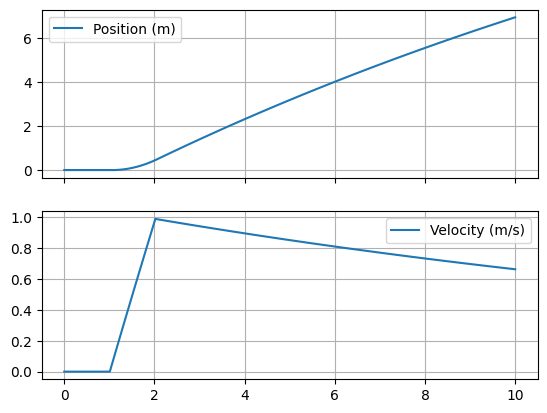

In [2]:
import matplotlib.pyplot as plt

t = np.linspace(0, 10, 100)  # time vector
x = np.zeros((2, len(t)))  # state vector: position and velocity
u = np.zeros((1, len(t)))  # input force vector
u[0, 10:20] = 1000  # apply force for a short duration

for i in range(1, len(t)):
    x_dot, _ = car.state_equation(x[:, i-1:i], u[:, i-1:i])
    x[:, i] = x[:, i-1] + x_dot * (t[i] - t[i-1])  # simple Euler integration

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(t, x[0, :], label='Position (m)')
ax[1].plot(t, x[1, :], label='Velocity (m/s)')

for a in ax:
    a.legend()
    a.grid()

plt.show()



We design a luenberger observer for the system. The observer equations are given by
$$
\dot{\hat{x}} = A\hat{x} + Bu + L(y - C\hat{x})
$$ 
By choosing a good $L$, we force the estimation error $e = x - \hat{x}$ to converge to zero quickly. The error dynamics are given by
$$
\dot{e} = (A - LC)e
$$
We can place the eigenvalues of $(A - LC)$ to achieve the desired convergence rate.

In [3]:
class CarWithObserver(Car):
    def __init__(self, m, d, b, L):
        super().__init__(m, d, b)
        self.L: np.array = L  # observer gain

    def observer_equation(self, x_hat, y, u):
        y_hat = self.C @ x_hat
        x_hat_dot = self.A @ x_hat + self.B @ u + self.L @ (y - y_hat)
        return x_hat_dot.flatten()


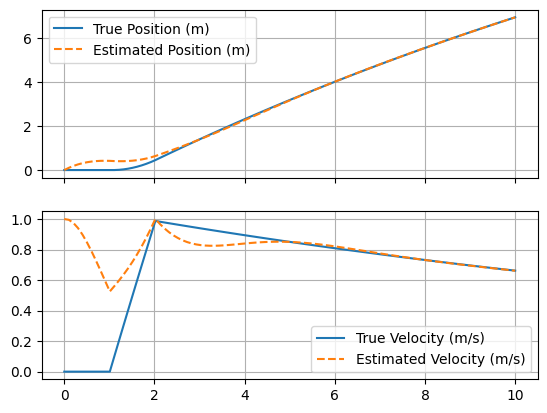

In [8]:
L = np.array([[1.5], [1.5]])

car_observer = CarWithObserver(m=1000, d=50, b=20000, L=L)

t = np.linspace(0, 10, 100)  # time vector
x = np.zeros((2, len(t)))  # true state vector: position and velocity
x_hat = np.zeros((2, len(t)))  # estimated state vector
u = np.zeros((1, len(t)))  # input force vector

x_hat[:, 0] = [0, 1]  # initial guess for the observer

u[0, 10:20] = 1000  # apply force for a short duration

for i in range(1, len(t)):
    # System dynamics
    x_dot, y = car.state_equation(
        x=x[:, i-1:i],
        u=u[:, i-1:i]
    )
    # simple Euler integration
    x[:, i] = x[:, i-1] + x_dot * (t[i] - t[i-1])

    # Observer dynamics
    x_hat_dot = car_observer.observer_equation(
        x_hat=x_hat[:, i-1:i],
        y=y,
        u=u[:, i-1:i]
    )
    # simple Euler integration
    x_hat[:, i] = x_hat[:, i-1]  + x_hat_dot * (t[i] - t[i-1])

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(t, x[0, :], label='True Position (m)')
ax[0].plot(t, x_hat[0, :], label='Estimated Position (m)', linestyle='--')
ax[1].plot(t, x[1, :], label='True Velocity (m/s)')
ax[1].plot(t, x_hat[1, :], label='Estimated Velocity (m/s)', linestyle='--')
for a in ax:
    a.legend()
    a.grid()